# Using Geospatial Data Blog: Seattle Pet Density

This notebook creates the visuals and code discussed in the blog __. Check out the blog here.

Goal: visualize the registered pet density across seattle neighborhoods.

## Import necessary packages

In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import folium

## Pet data

Load pet data

In [2]:
pet_df = pd.read_csv('data/Seattle_Pet_Licenses.csv')
pet_df.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,April 19 2003,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116
1,February 07 2006,75432,Pepper,Cat,Manx,Mix,98103
2,May 21 2014,727943,Ashley,Cat,Domestic Shorthair,NaN,98115
3,May 08 2015,833836,Lulu,Cat,LaPerm,NaN,98136
4,May 13 2015,361031,My Boy,Cat,Russian Blue,NaN,98121


In [45]:
pet_df['Species'].value_counts()

Dog     34607
Cat     16694
Goat       38
Pig         5
Name: Species, dtype: int64

In [3]:
pet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51754 entries, 0 to 51753
Data columns (total 7 columns):
License Issue Date    51754 non-null object
License Number        51754 non-null object
Animal's Name         51460 non-null object
Species               51754 non-null object
Primary Breed         51754 non-null object
Secondary Breed       24912 non-null object
ZIP Code              51344 non-null object
dtypes: object(7)
memory usage: 2.8+ MB


Clean pet data

In [4]:
# cut 9-digit zipcodes to the 5-digit version
pet_df['ZIP Code'] = pet_df['ZIP Code'].str[0:5]

# drop rows with NaN zip codes (~400 of 51k)
pet_df = pet_df.dropna(subset=['ZIP Code'])

# cast str zip codes to ints to match geo-dataset
pet_df['ZIP Code'] = pet_df['ZIP Code'].astype(int)

In [5]:
# create dataframe with the count of pets by zipcode
pet_counts = pd.DataFrame(pet_df['ZIP Code'].value_counts())
pet_counts = pet_counts.reset_index()
pet_counts.columns = ['ZIP', 'pets']

In [6]:
pet_counts

,ZIP,pets
0,98115,4541
1,98103,4398
2,98117,3809
3,98125,2801
4,98122,2481
...,...,...
139,98371,1
140,44223,1
141,80525,1
142,98167,1


## Shape Data

In [7]:
# load zip code shape data
zip_codes_gdf = gpd.read_file('data/shapes/Zip_Codes.shp')
zip_codes_gdf.head()

,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Leng,SHAPE_Area,geometry
0,1,98031,98031,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4..."
1,2,98032,98032,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411..."
2,3,98033,98033,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6..."
3,4,98034,98034,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7..."
4,5,98030,98030,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


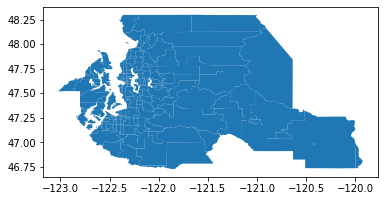

In [8]:
zip_codes_gdf.plot()

In [9]:
# load seattle shape
cities = gpd.read_file('data/shapes/Municipal_Boundaries.shp')
seattle = cities.loc[cities['CITYNAME'] == 'Seattle']
seattle = seattle.reset_index()
seattle_shp = seattle.loc[0, 'geometry']

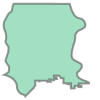

In [10]:
seattle_shp

In [11]:
# load seattle waterfront shape
waterfront = gpd.read_file('data/shapes/City_of_Seattle_Shoreline.shp')

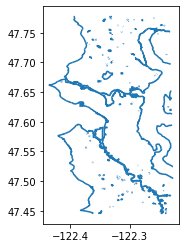

In [12]:
waterfront.plot();

## Filter for Seattle Zipcodes
Note that the zip codes file shows the county, but not the city for zipcodes.

### Shapely within

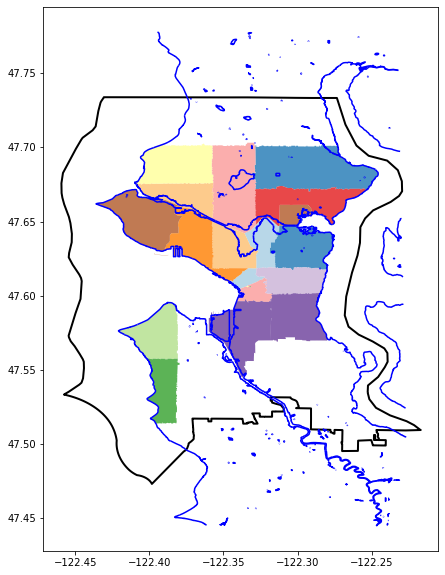

In [36]:
seattle_zips_within = zip_codes_gdf.loc[zip_codes_gdf.within(seattle_shp)]
fig, ax = plt.subplots(figsize=(10,10))
seattle.plot(ax=ax, color='white', edgecolor='black', linewidth=2)
waterfront.plot(ax=ax, color='blue')
seattle_zips_within.plot(ax=ax, cmap='Paired', alpha=.8)
plt.savefig('images/seattle_zips_within.png');

### Shapely intersects

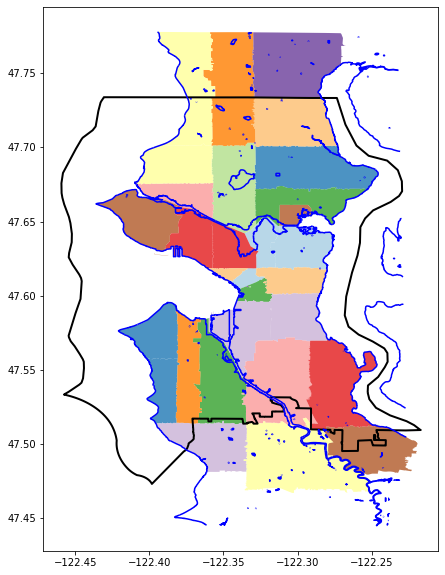

In [37]:
seattle_zips_intersects = zip_codes_gdf.loc[zip_codes_gdf.intersects(seattle_shp)]
fig, ax = plt.subplots(figsize=(10,10))
waterfront.plot(ax=ax, color='blue')
seattle_zips_intersects.plot(ax=ax, cmap='Paired', alpha=.8)
seattle.plot(ax=ax, color='#00000000', edgecolor='black', linewidth=2)
plt.savefig('images/seattle_zips_intersects.png');

### Shapely intersection

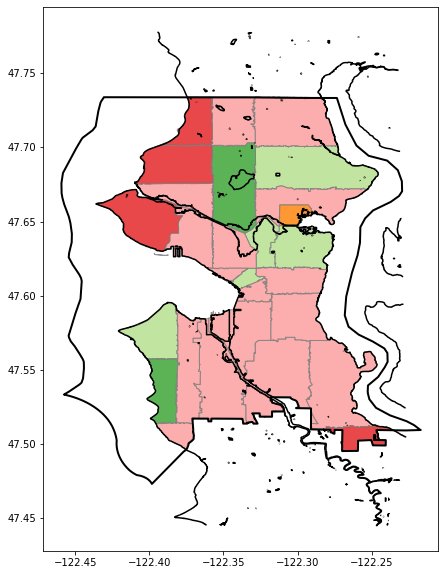

In [38]:
seattle_zips_intersection = zip_codes_gdf.intersection(seattle_shp)
fig, ax = plt.subplots(figsize=(10,10))
waterfront.plot(ax=ax, color='black')
seattle_zips_intersection.plot(ax=ax, cmap='Paired', alpha=.8, edgecolor='gray')
seattle.plot(ax=ax, color='#00000000', edgecolor='black', linewidth=2)
plt.savefig('images/seattle_zips_intersection.png');

### Add this intersection data to the zip codes dataframe

In [19]:
zip_codes_gdf['intersection'] = seattle_zips_intersection

## Combine shape and pet data

In [20]:
# create dataframe with the seattle in-city geometries
seattle_zip_geom = zip_codes_gdf.loc[:, ['ZIP', 'intersection']]

# name the geometry column 'geometry' for use with geopandas plotting
seattle_zip_geom.columns = ['ZIP', 'geometry']

# calculate the in-seattle area for each zipcode and add as a column
seattle_zip_geom['area'] = seattle_zip_geom.area

# drop zip codes that have no area in seattle
seattle_zip_geom = seattle_zip_geom.loc[seattle_zip_geom['area'] > 0]

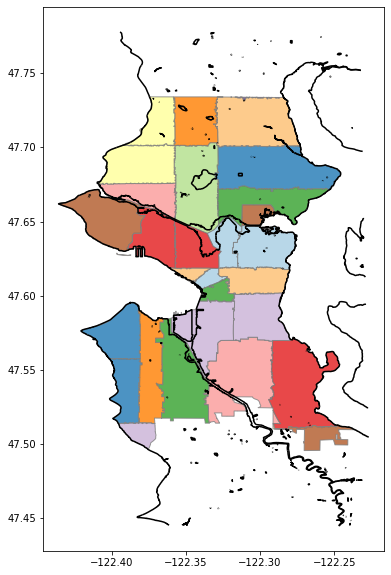

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
waterfront.plot(ax=ax, color='black')
seattle_zip_geom.plot(ax=ax, cmap='Paired', alpha=.8, edgecolor='gray');

In [22]:
# create a data frame with seattle zips and their respective pet counts
seattle_pets_zip = seattle_zip_geom.merge(pet_counts, on='ZIP')

# add pet_density column
seattle_pets_zip['pet_density'] = seattle_pets_zip['pets'] / seattle_pets_zip['area']
seattle_pets_zip

,ZIP,geometry,area,pets,pet_density
0,98101,"POLYGON ((-122.32785 47.61850, -122.32787 47.6...",1.633829e-04,696,4.259932e+06
1,98102,"POLYGON ((-122.31232 47.64705, -122.31233 47.6...",4.806127e-04,1640,3.412311e+06
2,98112,"MULTIPOLYGON (((-122.30683 47.64729, -122.3068...",9.805266e-04,1895,1.932635e+06
3,98115,"POLYGON ((-122.27294 47.70107, -122.27289 47.7...",2.018524e-03,4541,2.249664e+06
4,98116,"POLYGON ((-122.38139 47.59054, -122.38144 47.5...",9.047229e-04,2366,2.615165e+06
5,98136,"POLYGON ((-122.38085 47.55750, -122.38087 47.5...",7.013734e-04,1654,2.358230e+06
6,98164,"POLYGON ((-122.33124 47.60585, -122.33222 47.6...",8.639439e-07,14,1.620476e+07
7,98103,"POLYGON ((-122.32925 47.70319, -122.32920 47.7...",1.602479e-03,4398,2.744498e+06
8,98104,"POLYGON ((-122.31753 47.60141, -122.31696 47.6...",2.343303e-04,541,2.308707e+06
9,98105,"MULTIPOLYGON (((-122.30978 47.67381, -122.3065...",1.079571e-03,2029,1.879449e+06


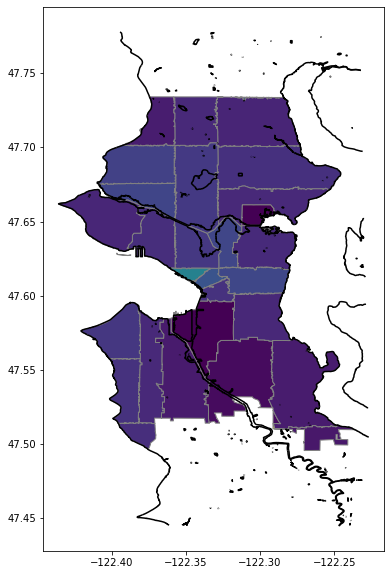

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
waterfront.plot(ax=ax, color='black')
seattle_pets_zip.plot(column='pet_density', ax=ax, edgecolor='gray')
plt.savefig('images/choropleth_seattle_pets_all.png');

Notice that two zip codes (98146, 98168) have a MUCH LARGER pet density than all other zip codes. Zip code 98146 includes only two square city blocks, one of which is the library. See further investigation below. Zip code 98168 is mostly in unincorporated King County, where the addresses are labeled "Seattle", but are not technically within Seattle city limits. I wonder if some non-Seattle resident pet owners in this area registered their pets with the city, not realizing that they are technically not city residents. Looking at the map below, we see that this small section is an industrial area near Boeing Field Airport. There is a Supervalue.

For now, I am choosing to drop these two zip codes so that the larger zip codes' pet densities are easier to distinguish.

In [26]:
seattle_pets_zip_dropped = seattle_pets_zip.drop(index=[6,25])
dropped_zips = seattle_pets_zip.iloc[[6,25]]

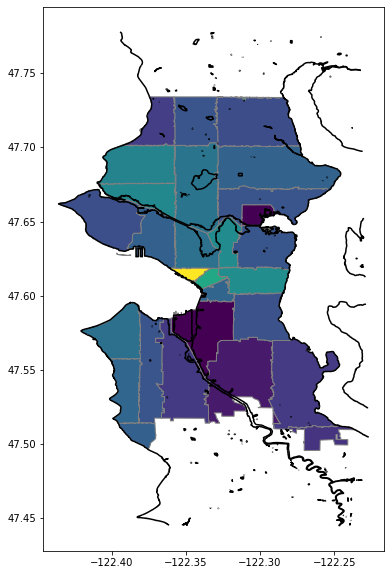

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
waterfront.plot(ax=ax, color='black')
dropped_zips.plot(ax=ax, color='gray')
seattle_pets_zip_dropped.plot(column='pet_density', ax=ax, edgecolor='gray');

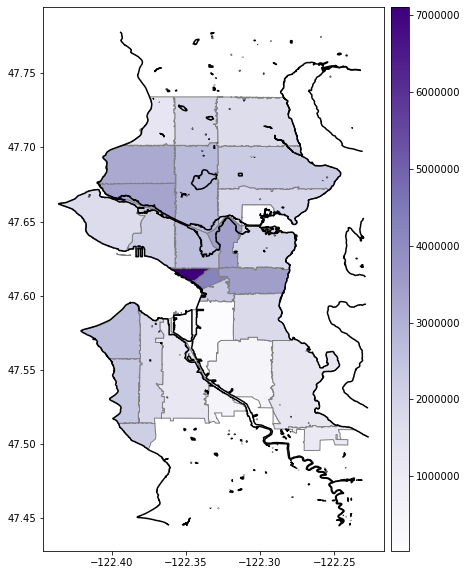

In [28]:
# adding a legend using code from http://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
waterfront.plot(ax=ax, color='black')
seattle_pets_zip_dropped.plot(column='pet_density', ax=ax, edgecolor='gray',
                      legend=True, cax=cax, cmap='Purples')

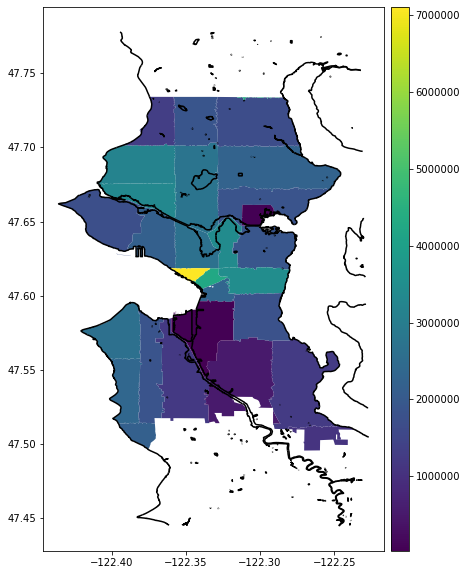

In [44]:
# adding a legend using code from http://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
waterfront.plot(ax=ax, color='black')
seattle_pets_zip_dropped.plot(column='pet_density', ax=ax, 
                      legend=True, cax=cax)
plt.savefig('images/final_pet_density.png');


## Visualize Small Zipcode Outliers

### Zip code 98164

In [30]:
from create_map import create_geo_map
%load_ext autoreload
%autoreload 2

In [31]:
# create map
m_98164 = create_geo_map(geo_df=seattle_pets_zip, index=6, location=[47.606315, -122.332410])

In [32]:
# add marker for building in zipcode
folium.Marker([47.606362, -122.331974], popup='<i>5th and Madison Condos</i>').add_to(m_98164)

In [33]:
m_98164

### Zip Code 98168

In [34]:
m_98168 = create_geo_map(seattle_pets_zip, 25, [47.510346, -122.289657], zoom=15)

In [35]:
m_98168